In [1]:
import numpy as np
import os
import tensorflow as tf
import urllib
import tensorflowjs as tfjs
import json
import keras
from dataclasses import dataclass
import matplotlib.pyplot as plt

2022-12-16 08:39:12.432305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 08:39:12.804938: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-16 08:39:26.213827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gmp/6.2.1/b1/lib:/software/glpk/4.65/lib:/software/zmq/4.2.3/b1/lib:/software/git/2.30.1/lib64:/software/gcc/7.3.0/lib64:/software/gcc/7.3.0/lib:/software/openmpi/4.0.4/b1/lib:/software/cuda/11.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


## Downloading solubility model from GitHub

In [3]:
# load json and create model
json_file = open('model_weights_seeded_SOL.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_weights_seeded_SOL.h5")
print("Loaded model from disk.")

2022-12-16 08:40:02.827382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-16 08:40:04.175720: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13330 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-12-16 08:40:04.176773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14623 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


Loaded model from disk.


# Getting test data

In [4]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/insoluble.npz",
    "insoluble.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/soluble.npz",
    "soluble.npz",
)
with np.load("soluble.npz") as r:
    pos_data = r['arr_0']
with np.load("insoluble.npz") as r:
    neg_data = r['arr_0']

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)


In [5]:

@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(labels), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0.01,
                lr=1e-4,
                drop_rate=0.2
               )

In [6]:
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
np.random.seed(0) # Note: seed 0 was used for training. DO NOT CHANGE!
                                 
i = np.arange(len(labels))
np.random.shuffle(i)
shuffled_labels = labels[i]
shuffled_features = features[i]
data = tf.data.Dataset.from_tensor_slices((shuffled_features, shuffled_labels)).map(lambda x,y: ((x, counts_aa(x)), y))
# now split into val, test, train and batch
N = len(data)  
L = None#features[0].shape[-1]
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
X_test = shuffled_features[:split]
y_test = shuffled_labels[:split]

In [8]:
use_tpu = False
decay_epochs = 50
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [9]:
y_hat_test = model.predict(test_data)
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Accuracy: {acc:.3f}')

2022-12-16 08:40:14.875101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


116/116 [==============================] - 10s 11ms/step
Best Threshold=0.516320, G-Mean=0.697
Accuracy: 0.710


In [10]:
# compiling the model again based on adjusted decision boundary threshold
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

In [11]:
def filter_lengths(X,y, min_length=10, max_length=80):
    test_lengths = np.count_nonzero(X, axis=1)
    filtered_idx = np.where((test_lengths>min_length) & (test_lengths<max_length))
    return X[filtered_idx], y[filtered_idx]

## No length filter 

In [19]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=1, max_length=200)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)
model.evaluate(filtered_test_data)

Number of test seqs: 1845
116/116 [==============================] - 1s 11ms/step - loss: 0.5770 - auc_1: 0.7561 - binary_accuracy: 0.7100


[0.5769950747489929, 0.7561261057853699, 0.7100270986557007]

(array([ 12.,  18.,  59., 128., 185., 263., 270., 337., 279., 294.]),
 array([ 20. ,  37.8,  55.6,  73.4,  91.2, 109. , 126.8, 144.6, 162.4,
        180.2, 198. ]),
 <BarContainer object of 10 artists>)

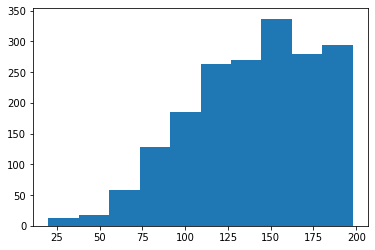

In [13]:
test_lengths = np.count_nonzero(X_test_f, axis=1)
plt.hist(test_lengths)

## Length filter 18 - 50

In [25]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=18, max_length=50)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)

y_hat_test_f = model.predict(filtered_test_data)
fpr, tpr, thresholds = roc_curve(y_test_f, y_hat_test_f, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test_f = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test_f]
acc = accuracy_score(y_test_f, adjusted_y_hat_test_f, normalize=True)
print(f'Accuracy: {acc:.3f}')

model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

model.evaluate(filtered_test_data)

Number of test seqs: 23
2/2 [==============================] - 4s 7ms/step
Best Threshold=0.598250, G-Mean=0.976
Accuracy: 0.913
2/2 [==============================] - 4s 11ms/step - loss: 0.2229 - auc_2: 0.9524 - binary_accuracy: 0.9130


[0.22285817563533783, 0.9523809552192688, 0.9130434989929199]

## Length filter 50 - 100

In [26]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=50, max_length=100)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)

y_hat_test_f = model.predict(filtered_test_data)
fpr, tpr, thresholds = roc_curve(y_test_f, y_hat_test_f, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test_f = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test_f]
acc = accuracy_score(y_test_f, adjusted_y_hat_test_f, normalize=True)
print(f'Accuracy: {acc:.3f}')

model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

model.evaluate(filtered_test_data)

Number of test seqs: 272
17/17 [==============================] - 4s 6ms/step
Best Threshold=0.585481, G-Mean=0.751
Accuracy: 0.765
17/17 [==============================] - 4s 10ms/step - loss: 0.5422 - auc_3: 0.7949 - binary_accuracy: 0.7647


[0.5421819090843201, 0.7949349880218506, 0.7647058963775635]

## Length filter 100 - 150

In [27]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=100, max_length=150)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)

y_hat_test_f = model.predict(filtered_test_data)
fpr, tpr, thresholds = roc_curve(y_test_f, y_hat_test_f, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test_f = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test_f]
acc = accuracy_score(y_test_f, adjusted_y_hat_test_f, normalize=True)
print(f'Accuracy: {acc:.3f}')

model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

model.evaluate(filtered_test_data)

Number of test seqs: 715
45/45 [==============================] - 4s 10ms/step
Best Threshold=0.510299, G-Mean=0.692
Accuracy: 0.702
45/45 [==============================] - 4s 11ms/step - loss: 0.5798 - auc_4: 0.7549 - binary_accuracy: 0.7021


[0.5798361897468567, 0.7549368143081665, 0.7020978927612305]

## Length filter 150 - 200

In [28]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=150, max_length=200)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)

y_hat_test_f = model.predict(filtered_test_data)
fpr, tpr, thresholds = roc_curve(y_test_f, y_hat_test_f, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test_f = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test_f]
acc = accuracy_score(y_test_f, adjusted_y_hat_test_f, normalize=True)
print(f'Accuracy: {acc:.3f}')

model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

model.evaluate(filtered_test_data)

Number of test seqs: 806
51/51 [==============================] - 4s 11ms/step
Best Threshold=0.516122, G-Mean=0.679
Accuracy: 0.705
51/51 [==============================] - 4s 12ms/step - loss: 0.5969 - auc_5: 0.7380 - binary_accuracy: 0.7047


[0.5968638062477112, 0.7380302548408508, 0.7047146558761597]

## Length filter 18 - 100

In [29]:
X_test_f, y_test_f = filter_lengths(X_test, y_test, min_length=18, max_length=100)
print(f'Number of test seqs: {len(X_test_f)}')
filtered_test_data = tf.data.Dataset.from_tensor_slices((X_test_f, y_test_f)).map(lambda x,y: ((x, counts_aa(x)), y))
filtered_test_data = filtered_test_data.batch(config.batch_size)

y_hat_test_f = model.predict(filtered_test_data)
fpr, tpr, thresholds = roc_curve(y_test_f, y_hat_test_f, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test_f = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test_f]
acc = accuracy_score(y_test_f, adjusted_y_hat_test_f, normalize=True)
print(f'Accuracy: {acc:.3f}')

model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=best_accuracy_threshold)])

model.evaluate(filtered_test_data)

Number of test seqs: 295
19/19 [==============================] - 4s 7ms/step
Best Threshold=0.585481, G-Mean=0.778
Accuracy: 0.780
19/19 [==============================] - 4s 9ms/step - loss: 0.5173 - auc_6: 0.8138 - binary_accuracy: 0.7797


[0.5172854661941528, 0.8138336539268494, 0.7796609997749329]